In [38]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

In [39]:
import datetime
import re

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
from matplotlib import dates as mdates
import numpy as np
import pandas as pd

from funcs.tse import get_ticker_name_list
from modules.psar import RealtimePSAR

In [40]:
pattern = re.compile(r".+([0-9]{4})([0-9]{2})([0-9]{2})\.xlsx")

In [46]:
name_excel = "../excel/tick_20250619.xlsx"
ticker = "7011"
#ticker = "7203"
#ticker = "8306"

m = pattern.match(name_excel)
if m:
    year = m.group(1)
    month = m.group(2)
    day = m.group(3)
else:
    year = "1970"
    month = "01"
    day = "01"
date_str = f"{year}-{month}-{day}"
df = pd.read_excel(name_excel, sheet_name=ticker)
df.index = pd.to_datetime([datetime.datetime.fromtimestamp(t) for t in df["Time"]])
df

,Time,Price
2025-06-18 09:00:03.483444,1.750205e+09,3548
2025-06-18 09:00:04.493264,1.750205e+09,3548
2025-06-18 09:00:05.503264,1.750205e+09,3556
2025-06-18 09:00:06.516372,1.750205e+09,3556
2025-06-18 09:00:07.523290,1.750205e+09,3544
...,...,...
2025-06-18 15:24:55.774353,1.750228e+09,3500
2025-06-18 15:24:56.782476,1.750228e+09,3500
2025-06-18 15:24:57.776997,1.750228e+09,3500
2025-06-18 15:24:58.783988,1.750228e+09,3500


In [47]:
def get_psar(df: pd.DataFrame, af_init=0.0, af_step=0.0001, af_max=0.01):
    rpsar = RealtimePSAR(af_init, af_step, af_max)
    df_psar = pd.DataFrame({
        "Price": [],
        "Trend": [],
        "PSAR": []
    })
    for t in df.index:
        y = df.at[t, "Price"]
        ret = rpsar.add(y)
        df_psar.at[t, "Price"] = y
        df_psar.at[t, "Trend"] = ret.trend
        df_psar.at[t, "PSAR"] = ret.psar
    ser_bull = df_psar[df_psar["Trend"] > 0]["PSAR"]
    ser_bear = df_psar[df_psar["Trend"] < 0]["PSAR"]
    return ser_bull, ser_bear

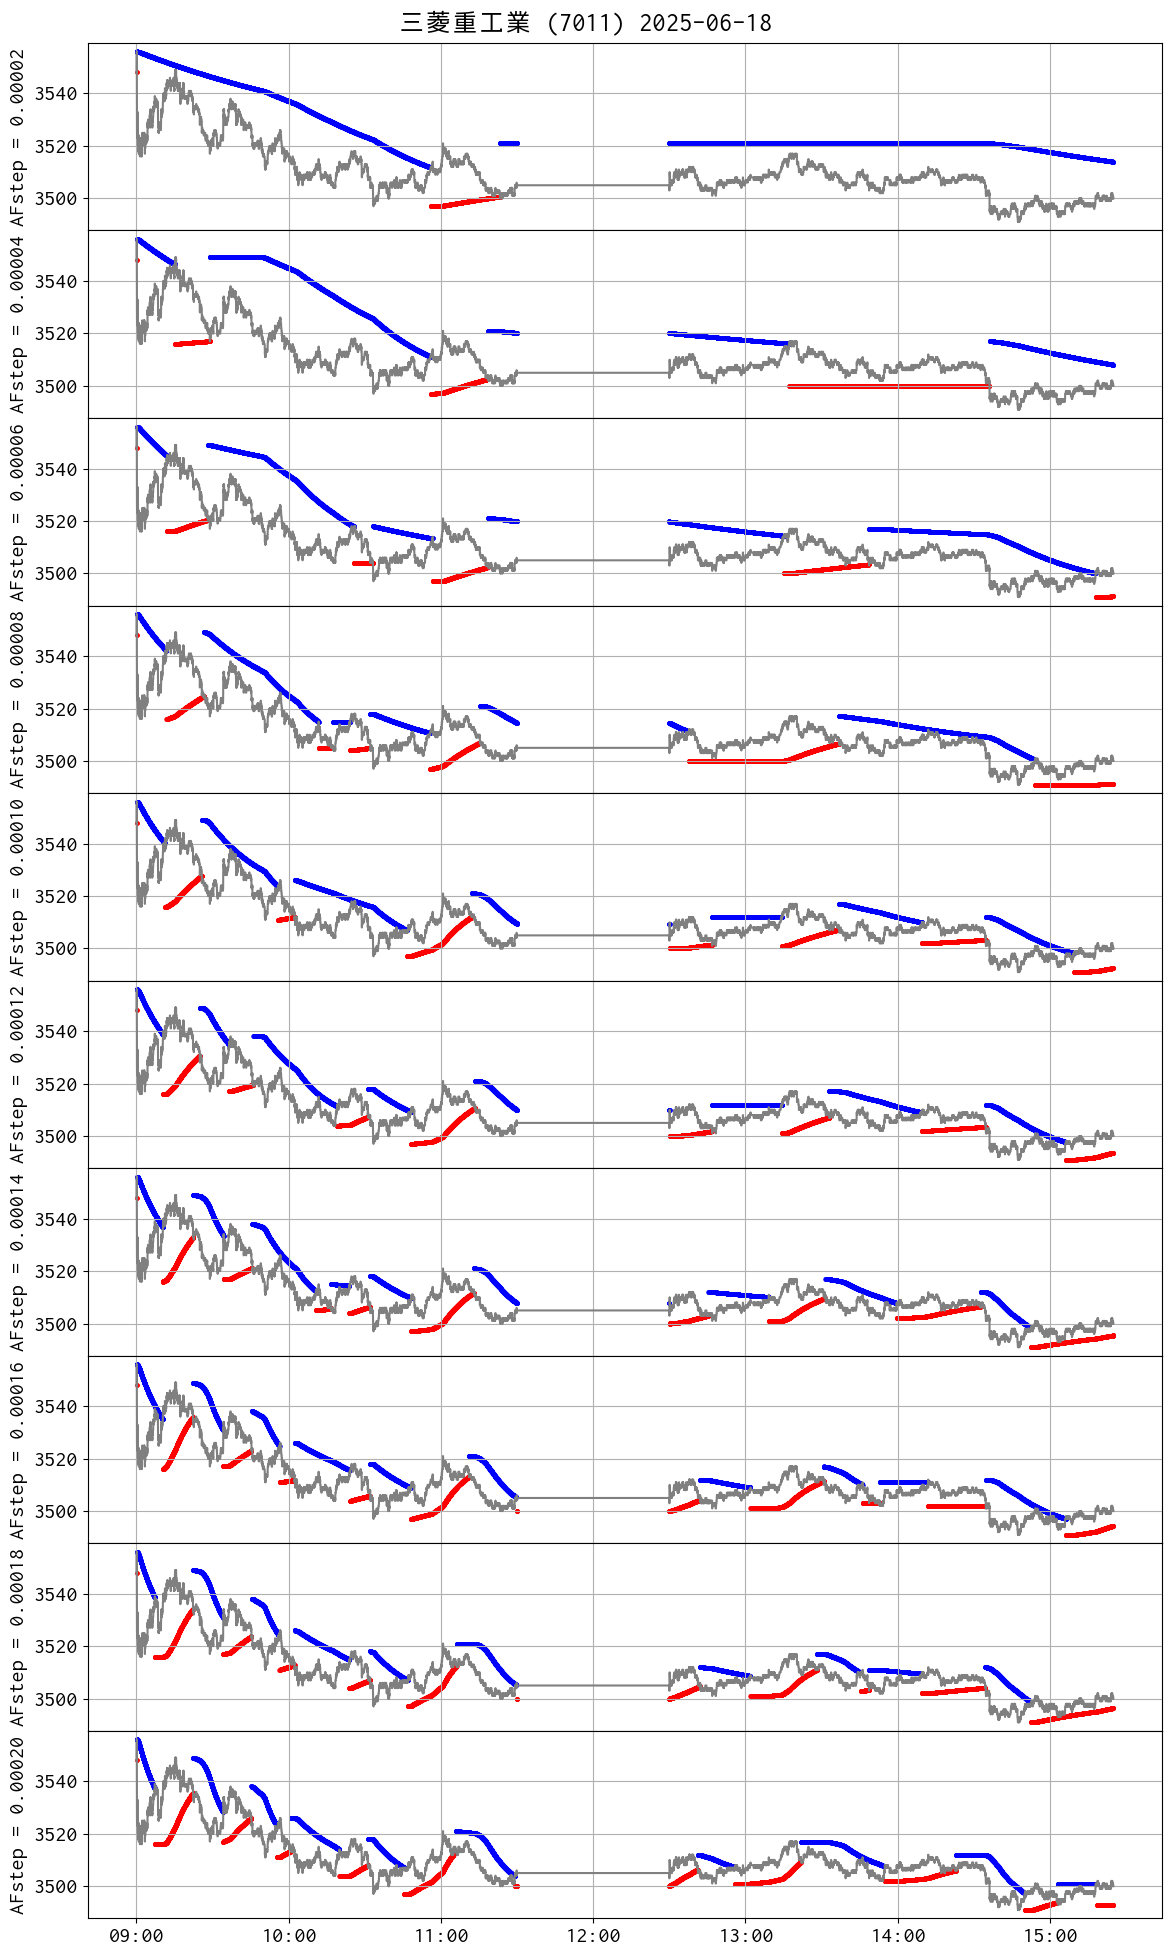

In [48]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 16
fig = plt.figure(figsize=(12, 20))
ax = dict()
n = 10
gs = fig.add_gridspec(
    n, 1, wspace=0.0, hspace=0.0, height_ratios=[1 for i in range(n)]
)
for i, axis in enumerate(gs.subplots(sharex="col")):
    ax[i] = axis
    ax[i].grid()

factor = 3
for i in range(n):
    df_med = pd.DataFrame(df["Price"].rolling(factor, min_periods=1).median())
    ax[i].plot(df_med, color="gray")
    af_init = 0
    af_step = 0.00001 * (i + 1) * 2
    af_max = af_step * 100
    ser_bull, ser_bear = get_psar(df_med, af_init, af_step, af_max)
    ax[i].scatter(x=ser_bull.index, y=ser_bull, s=5, c="red")
    ax[i].scatter(x=ser_bear.index, y=ser_bear, s=5, c="blue")
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    ax[i].set_ylabel(f"AFstep = {af_step:.5f}")

dict_name = get_ticker_name_list([ticker])
plt.suptitle(f"{dict_name[ticker]} ({ticker}) {date_str}")
plt.tight_layout()
plt.savefig(f"screenshots/psar_med_{ticker}_{date_str}.png" )
plt.show()